## Importing Required Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np
from PIL import Image

%matplotlib inline

np.random.seed(0)

In [2]:
# raw data location
data_path = 'visapy_data.npy'

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(3)
torch.manual_seed(0)

## Spike Detection

In [5]:
somapos = np.loadtxt('ViSAPy_somapos.gdf')
ground_truth = np.loadtxt('ViSAPy_ground_truth.gdf')

In [45]:
ground_truth = ground_truth.astype(int)
somapos = np.array([somapos[:,0], somapos[:,1]])

(2, 56)
[[-15.481029    13.5634118   53.20338083  76.46626375   1.5823363
   30.57263359  54.90287328  84.4684755  -14.63904256  20.65160843
   48.05836036  62.46587907   6.20463663  32.86167141  56.63585225
   90.36306974 -16.70572232  21.92998409  43.73117057  65.9701298
    7.4942574   21.5630916   58.86033513  91.96037958 -19.23563551
    8.78703919  43.0325968   78.06279008   2.06295723  37.18217462
   56.40944801  84.44129449 -11.07896732  12.03236033  42.42885691
   66.41585518   7.67215616  27.68847389  60.57670279  82.26593671
    1.24627243  20.96538809  35.03627356  71.21975778  -2.07878851
   27.73676679  68.29533071  89.17156341  -4.32102054  12.41516046
   39.98196364  67.64586423   2.68942468  29.19640478  62.60338484
   86.68857442]
 [-14.97522592  -9.80824596 -14.78121854 -11.87462894  10.15013626
   15.5394032   19.95938411  14.24633527  29.02344793  36.17720134
   34.22882047  29.46580954  66.89060094  65.09189524  54.52997833
   58.16427204  85.04998913  86.07177711

In [46]:
print(ground_truth.shape)
print(somapos.shape)

(64441, 2)
(2, 56)


## Listing down all event frames

##### There are 102 channels which have recorded 1200001 data points each. Hence we have 1200001 frames to assess

In [47]:
data = np.load('visapy_data.npy')
# i = 101
# print(data[i*1200001: (i+1)*1200001])

In [48]:
frame_set = data.reshape((1200001,102))
print("Frame shape: ", frame_set.shape)
print("Whole Dataset: ", frame_set)

Frame shape:  (1200001, 102)
Whole Dataset:  [[  4 -18   3 ...   5 -11  -4]
 [  3 -26  -4 ...   6 -13   6]
 [  3 -25  -6 ...   5 -18   3]
 ...
 [  1  32  -5 ...   7   2   0]
 [-17  27  -9 ...  12  -1  11]
 [-13  21  -8 ...  15   0  10]]


##### Finding electrode positions

In [49]:
x_path = 'z_integer.npy'
y_path = 'y_integer.npy'
elec_x_int = np.load(x_path)
elec_y_int = np.load(y_path)

In [50]:
ky = 9 / np.max(np.diff(sorted(elec_y_int)))
elec_x = elec_x_int * ky
elec_y = elec_y_int * ky
elec_x -= np.min(elec_x)
elec_y -= np.min(elec_y)

In [51]:
datapoints = []
for i in range(len(elec_x)):
    datapoints.append([elec_x[i], elec_y[i]])
datapoints = np.asarray(datapoints)
print(datapoints)

[[ 59.54058193 179.98346095]
 [  0.         233.97886677]
 [ 74.42572741 242.97794793]
 [ 59.54058193  17.99816233]
 [ 29.77029096  35.99632466]
 [ 59.54058193 143.98621746]
 [ 44.65543645 242.97794793]
 [ 14.88514548 296.97243492]
 [ 74.42572741  44.99540582]
 [  0.         107.9898928 ]
 [ 29.77029096 143.98621746]
 [  0.          17.99816233]
 [ 59.54058193  53.99448698]
 [ 44.65543645  80.99264931]
 [ 74.42572741 170.98437979]
 [ 44.65543645 206.98070444]
 [  0.         197.98162328]
 [ 14.88514548 278.97427259]
 [ 44.65543645 296.97243492]
 [ 14.88514548  44.99540582]
 [ 59.54058193  89.99173047]
 [  0.         215.9797856 ]
 [ 74.42572741 278.97427259]
 [ 14.88514548  26.99724349]
 [ 44.65543645  44.99540582]
 [ 44.65543645  98.99081164]
 [ 74.42572741 152.98621746]
 [ 29.77029096   0.        ]
 [ 74.42572741  26.99724349]
 [  0.          53.99448698]
 [ 44.65543645 134.98713629]
 [ 44.65543645  62.99356815]
 [ 59.54058193 287.97335375]
 [ 59.54058193 215.9797856 ]
 [ 59.54058193

##### Converting signals from each electrode in one frame to images

In [30]:
print(elec_x[35], elec_y[35])

29.770290964777928 71.99356814701378


48 59.54058192955597 269.97519142419594


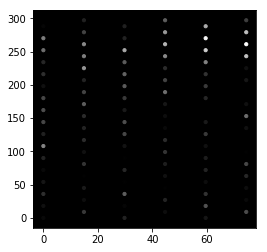

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.set_facecolor("black")
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
#ax.set_yticklabels([])
#ax.set_xticklabels([])
frame_set_use = np.abs(frame_set)
max_value = np.amax(frame_set_use)
frame_set_use = max_value - frame_set_use
normalised_frame = frame_set_use/max_value
colors = normalised_frame[10029, :]
i = np.argmax(colors) - 1
print(i, elec_x[i], elec_y[i])
ax.scatter(elec_x, elec_y, c=colors, s=10, cmap='Greys')
plt.show()

##### Better visualisation

In [52]:
frame_set_use = np.abs(frame_set)
max_value = np.amax(frame_set_use)
frame_set_use = max_value - frame_set_use
normalised_frame = frame_set_use/max_value

In [55]:
%matplotlib notebook

plt.ioff()
for i in range(ground_truth.shape[0]):
    fname = "frames/frame_"+str(ground_truth[i, 0])+"_"+str(ground_truth[i, 1])+".png"
    fig, ax = plt.subplots(1, 1, figsize=(4,4), facecolor='black')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_facecolor("black")
    colors = normalised_frame[ground_truth[i, 1], :]
    ax.scatter(elec_x, elec_y, c=colors, s=10, cmap='Greys')
    fig.set_tight_layout(True)
    fig.savefig(fname, frameon=False, facecolor='black')
    plt.close()

## Incorporating attention on the images

In [57]:
# A list of all time and channel combinations which have spikes
list_times_ch = []
for i in range(ground_truth.shape[0]):
    list_times_ch.append((ground_truth[i, 0], ground_truth[i, 1]))

In [58]:
def attention_image(index, elec_val, electrode_loc, image_set):
    im = np.copy(image_set[index])
    sh = im.shape[0] - 40
    max_x = max(elec_x)
    max_y = max(elec_y)
    elec_locate = copy.deepcopy(electrode_loc[elec_val, :])
    elec_locate[0] = int(round(elec_locate[0]/max_x * sh + 20, 0))
    elec_locate[1] = im.shape[0] - int(round(elec_locate[1]/max_y * sh + 20, 0))
    
    rows, cols = im.shape

    # building the kernel
    kernel_x = cv2.getGaussianKernel(3*cols, 80)
    kernel_y = cv2.getGaussianKernel(3*rows, 80)
    mask = kernel_y*kernel_x.T
    mask = mask/np.linalg.norm(mask)

    centre = int(round(1.5*rows, 0))
    mask = mask[centre-int(elec_locate[1]):centre+rows-int(elec_locate[1]), centre-int(elec_locate[0]):centre+cols-int(elec_locate[0])]

    temp = np.copy(im)
    temp = temp*mask
    temp = temp/np.amax(temp)
    
    return temp

## Loading the image files into dictionary with time and channel as key

In [4]:
import cv2
import copy

In [7]:
image_data = {}

#for i in range(ground_truth.shape[0]):
filename = "frames/frame_395_26.png"
temp_pic = cv2.imread(filename)
temp_pic = cv2.cvtColor(temp_pic, cv2.COLOR_RGB2GRAY)
temp_pic = temp_pic/255
temp_pic = np.array(temp_pic)
print(temp_pic.shape)

(288, 288)


In [38]:
%matplotlib inline

## Loading the locations and images into dictionary with time and channel as key

In [81]:
folder = "frames_gdf/" #For Attention based images
#folder = "frames/" #For Original Images
image_data = {}

for i in range(ground_truth.shape[0]):
    filename = folder+"frame_"+str(ground_truth[i, 0])+"_"+str(ground_truth[i, 1])+".png"
    temp_pic = cv2.imread(filename)
    temp_pic = cv2.cvtColor(temp_pic, cv2.COLOR_RGB2GRAY)
    temp_pic = temp_pic/255
    image_data[(ground_truth[i, 0], ground_truth[i, 1])] = temp_pic

In [86]:
location = {}

for i in range(ground_truth.shape[0]):
    location[(ground_truth[i, 0], ground_truth[i, 1])] = (somapos[0, ground_truth[i, 0]-1], somapos[1, ground_truth[i, 0]-1])

In [83]:
print(list_times_ch)

[(47, 10029), (35, 10078), (27, 10094), (42, 10109), (41, 10110), (55, 10110), (49, 10135), (20, 10160), (21, 10169), (52, 10170), (30, 10201), (25, 10223), (13, 10225), (8, 10235), (26, 10252), (51, 10299), (2, 10306), (50, 10308), (40, 10322), (1, 10327), (28, 10365), (32, 10382), (27, 10389), (44, 10410), (46, 10411), (56, 10419), (29, 10424), (36, 10431), (19, 10433), (53, 10435), (39, 10441), (10, 10443), (18, 10489), (24, 10504), (15, 10506), (47, 10510), (7, 10513), (48, 10515), (14, 10528), (54, 10587), (31, 10609), (25, 10616), (45, 10616), (30, 10641), (2, 10645), (37, 10660), (23, 10670), (26, 10677), (27, 10687), (52, 10692), (22, 10707), (40, 10709), (21, 10722), (11, 10752), (17, 10755), (41, 10792), (49, 10798), (8, 10865), (36, 10871), (51, 10892), (35, 10902), (1, 10919), (53, 10925), (13, 10929), (55, 10947), (47, 10966), (2, 10974), (27, 10983), (25, 10999), (6, 11040), (28, 11040), (30, 11088), (39, 11088), (40, 11088), (26, 11101), (56, 11130), (29, 11143), (32, 11

### Splitting in Train-Test Data

In [85]:
train_lim = (int)(0.8*len(list_times_ch))

list_times_ch_train = list_times_ch[:train_lim]
list_times_ch_test = list_times_ch[train_lim:]

print(len(list_times_ch_train), len(list_times_ch_test))

51552 12889


# Designing the model

In [163]:
# #torch.cuda.set_device(1)

# class LocatorCNN(nn.Module):
#     def __init__(self, dilate=1):
#         super(LocatorCNN, self).__init__()
#         self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
#         self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, dilation=dilate)
#         self.batchnorm1 = nn.BatchNorm2d(32)

#         self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
#         self.conv_layer4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, dilation=dilate)
#         #self.batchnorm2 = nn.BatchNorm2d(64)
        
#         self.conv_layer5 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
#         self.conv_layer6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, dilation=dilate)
#         #self.conv_layer7 = nn.Conv2d(128, 128, kernel_size=5, stride=1)
#         #self.batchnorm3 = nn.BatchNorm2d(128)
    
#         self.maxpool = nn.MaxPool2d(kernel_size=2)
        
#         self.drop2 = nn.Dropout2d(p=0.1)
#         self.drop1 = nn.Dropout(p=0.05)
        
#         self.activation_layer_2d = nn.Tanh()
#         self.activation_layer = nn.ELU()
        
#         #self.linear_0 = nn.Linear(107648, 4096)
#         self.linear_1 = nn.Linear(115200, 2048) #with maxpooling
#         #self.linear_1 = nn.Linear(9750528, 2048)
#         self.linear_2 = nn.Linear(2048, 512)
#         self.linear_3 = nn.Linear(512, 128)
#         self.linear_4 = nn.Linear(128, 32)
#         self.linear_5 = nn.Linear(33, 8)
#         self.linear_6 = nn.Linear(8, 2)
    
#     def forward(self, x, dim, channel):
#         x = x.view((1, 1, dim, -1))
#         channel = channel.view(-1)

#         out = self.conv_layer1(x)
#         out = self.activation_layer_2d(out)
#         #print(out.shape)
#         out = self.conv_layer2(out)
#         out = self.batchnorm1(out)
#         #print(out.shape)
#         out = self.activation_layer_2d(out)
#         out = self.maxpool(out)
#         out = self.drop2(out)
#         #print(out.shape)
        
#         out = self.conv_layer3(out)
#         out = self.activation_layer_2d(out)
#         #print(out.shape)
#         out = self.conv_layer4(out)
#         out = self.activation_layer_2d(out)
#         #print(out.shape)
#         #out = self.batchnorm2(out)
#         out = self.maxpool(out)
#         out = self.drop2(out)
#         #print(out.shape)
        
#         out = self.conv_layer5(out)
#         out = self.activation_layer_2d(out)
#         #out = self.batchnorm3(out)
#         #print(out.shape)
#         out = self.conv_layer6(out)
#         out = self.activation_layer_2d(out)
#         out = self.maxpool(out)
#         #out = self.drop2(out)
#         #print(out.shape)
        
#         out = out.view(-1)
        
#         #out = self.linear_0(out)
#         #out = self.activation_layer(out)
#         #out = self.drop1(out)
#         out = self.linear_1(out)
#         out = self.activation_layer(out)
#         out = self.linear_2(out)
#         out = self.activation_layer(out)
#         out = self.drop1(out)
#         out = self.linear_3(out)
#         out = self.activation_layer(out)
#         out = self.linear_4(out)
#         out = self.activation_layer(out)
#         out = torch.cat((out, channel))
#         out = self.linear_5(out)
#         out = self.activation_layer(out)
#         out = self.linear_6(out)
        
#         return out

### Training the Network

In [141]:
# import random
# random.seed(0)

# def train_cnn(model, times_ch, images, location, criterion, optimizer, epoch_range,  batch_size):
#     losses = []
#     for num_epoch in range(epoch_range):
#         selected = random.sample(range(0, len(times_ch)), batch_size)
#         for i in range(len(selected)):
#             pointer = times_ch[i]
#             x = images[pointer]
#             dim = x.shape[0]
#             x = torch.from_numpy(x).float().cuda()
#             ch = torch.from_numpy(np.array([pointer[1]])).float().cuda()
#             #---------FORWARD------------#
#             out = model.forward(x, dim, ch)
#             out = torch.tensor(out).float().cuda()
#             loc = np.array(location[pointer])
#             loc = torch.from_numpy(loc).float().cuda()
#             #print(pointer, out, loc)
#             loss = criterion(out, loc)
#             #---------BACKWARD------------#
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#         losses.append(loss.data[0])
#         print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
#                                                               loss.data[0], sum(losses[-10:])/len(losses[-10:])))
#     return out, losses

In [142]:
# def init_weights(layer):
#     if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
#         nn.init.xavier_normal_(layer.weight)

## With Maxpooling

In [114]:
# epoch_range = 500
# batch_size = 200
# learning_rate = 0.0001

# cnn_1 = LocatorCNN().cuda()
# cnn_1.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     cnn_1.parameters(), lr=learning_rate)

# out, losses_1 = train_cnn(cnn_1, list_times_ch_train, image_data, location, criterion, optimizer, epoch_range, batch_size)

epoch [1/500], loss:3307.04663, avg:3307.04663
epoch [2/500], loss:826.42041, avg:2066.73340
epoch [3/500], loss:601.65991, avg:1578.37573
epoch [4/500], loss:389.04922, avg:1281.04407
epoch [5/500], loss:614.50256, avg:1147.73572
epoch [6/500], loss:68.82169, avg:967.91675
epoch [7/500], loss:94.81192, avg:843.18756
epoch [8/500], loss:94.59319, avg:749.61322
epoch [9/500], loss:105.86699, avg:678.08588
epoch [10/500], loss:21.77264, avg:612.45453
epoch [11/500], loss:124.64659, avg:294.21454
epoch [12/500], loss:259.59616, avg:237.53206
epoch [13/500], loss:143.12421, avg:191.67850
epoch [14/500], loss:546.59595, avg:207.43318
epoch [15/500], loss:34.30343, avg:149.41328
epoch [16/500], loss:10.27701, avg:143.55881
epoch [17/500], loss:8.68338, avg:134.94597
epoch [18/500], loss:75.62697, avg:133.04933
epoch [19/500], loss:353.55511, avg:157.81815
epoch [20/500], loss:1092.95703, avg:264.93658
epoch [21/500], loss:235.24138, avg:275.99606
epoch [22/500], loss:132.54903, avg:263.29135

epoch [185/500], loss:6.80667, avg:8.54591
epoch [186/500], loss:14.53522, avg:7.50080
epoch [187/500], loss:1.98151, avg:7.47542
epoch [188/500], loss:3.01795, avg:7.76745
epoch [189/500], loss:52.45105, avg:11.47182
epoch [190/500], loss:35.90912, avg:14.94353
epoch [191/500], loss:28.75213, avg:17.45953
epoch [192/500], loss:11.34189, avg:18.27308
epoch [193/500], loss:24.19493, avg:20.06406
epoch [194/500], loss:10.37954, avg:18.93700
epoch [195/500], loss:16.98934, avg:19.95527
epoch [196/500], loss:1.21452, avg:18.62320
epoch [197/500], loss:7.44658, avg:19.16970
epoch [198/500], loss:11.63299, avg:20.03121
epoch [199/500], loss:43.70580, avg:19.15668
epoch [200/500], loss:19.71269, avg:17.53704
epoch [201/500], loss:0.04123, avg:14.66595
epoch [202/500], loss:0.12934, avg:13.54469
epoch [203/500], loss:33.66222, avg:14.49142
epoch [204/500], loss:7.28735, avg:14.18221
epoch [205/500], loss:8.64386, avg:13.34766
epoch [206/500], loss:2.73146, avg:13.49935
epoch [207/500], loss:8.

epoch [370/500], loss:3.34100, avg:22.69623
epoch [371/500], loss:1.93192, avg:21.94449
epoch [372/500], loss:3.93386, avg:22.27622
epoch [373/500], loss:2.76901, avg:12.75993
epoch [374/500], loss:17.24676, avg:9.72158
epoch [375/500], loss:18.70005, avg:8.18880
epoch [376/500], loss:1.10547, avg:8.28879
epoch [377/500], loss:72.89899, avg:14.89113
epoch [378/500], loss:6.21338, avg:15.17393
epoch [379/500], loss:3.76528, avg:13.19057
epoch [380/500], loss:14.13164, avg:14.26964
epoch [381/500], loss:13.34276, avg:15.41072
epoch [382/500], loss:3.34873, avg:15.35221
epoch [383/500], loss:39.08611, avg:18.98392
epoch [384/500], loss:2.86781, avg:17.54602
epoch [385/500], loss:20.13002, avg:17.68902
epoch [386/500], loss:11.07921, avg:18.68639
epoch [387/500], loss:4.80860, avg:11.87735
epoch [388/500], loss:10.84218, avg:12.34023
epoch [389/500], loss:1.59866, avg:12.12357
epoch [390/500], loss:88.80804, avg:19.59121
epoch [391/500], loss:2.48106, avg:18.50504
epoch [392/500], loss:46.

In [85]:
H.spikes.loc[H.spikes['ch'] == 102]

,ch,t,Amplitude,x,y,Shape


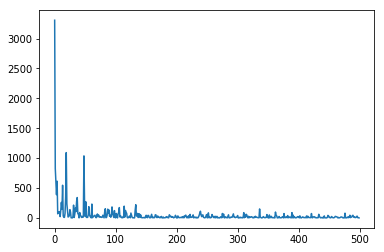

In [116]:
plt.figure()
plt.plot(losses_1)
plt.show()

In [118]:
index = 0
for index in [0, 44, 65, 22, 90]:
    pointer = list_times_ch_test[index]
    x = image_data[pointer]
    dim = x.shape[0]
    l = location[pointer]
    x = torch.from_numpy(x).float().cuda()
    ch = torch.from_numpy(np.array([pointer[1]])).float().cuda()
    out = cnn_1.forward(x, dim, ch)
    print(pointer)
    print(out)
    print(l)
    print('--------------')

(878177, 95)
tensor([  54.4628,  227.0009], device='cuda:2')
(61.067, 224.507)
--------------
(880652, 96)
tensor([ 51.2316,  27.9864], device='cuda:2')
(50.012, 29.363)
--------------
(881943, 2)
tensor([  62.8280,  263.8462], device='cuda:2')
(67.13, 252.341)
--------------
(879457, 93)
tensor([ 53.1142,  72.5681], device='cuda:2')
(43.886, 29.969)
--------------
(883433, 60)
tensor([  15.8789,  204.0969], device='cuda:2')
(10.61, 161.915)
--------------


## With error criterion multiplied by 100

In [126]:
# epoch_range = 500
# batch_size = 200
# learning_rate = 0.0001

# cnn_2 = LocatorCNN().cuda()
# cnn_2.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     cnn_2.parameters(), lr=learning_rate)

# out, losses_2 = train_cnn(cnn_2, list_times_ch_train, image_data, location, criterion, optimizer, epoch_range, batch_size)

epoch [1/500], loss:107844728.00000, avg:107844728.00000
epoch [2/500], loss:33117040.00000, avg:70480880.00000
epoch [3/500], loss:13955602.00000, avg:51639120.00000
epoch [4/500], loss:22847578.00000, avg:44441236.00000
epoch [5/500], loss:1532065.25000, avg:35859404.00000
epoch [6/500], loss:3169918.50000, avg:30411156.00000
epoch [7/500], loss:2871966.75000, avg:26476986.00000
epoch [8/500], loss:984597.18750, avg:23290436.00000
epoch [9/500], loss:1126634.75000, avg:20827792.00000
epoch [10/500], loss:2619733.00000, avg:19006986.00000
epoch [11/500], loss:1293839.62500, avg:8351897.50000
epoch [12/500], loss:1562068.37500, avg:5196400.50000
epoch [13/500], loss:7976879.50000, avg:4598528.00000
epoch [14/500], loss:13820074.00000, avg:3695777.75000
epoch [15/500], loss:378424.56250, avg:3580413.75000
epoch [16/500], loss:1878175.12500, avg:3451239.25000
epoch [17/500], loss:1643508.25000, avg:3328393.50000
epoch [18/500], loss:424301.87500, avg:3272364.00000
epoch [19/500], loss:27

epoch [155/500], loss:63549.02734, avg:553681.18750
epoch [156/500], loss:3108551.00000, avg:786652.43750
epoch [157/500], loss:36947.91406, avg:776040.43750
epoch [158/500], loss:1404427.37500, avg:783666.75000
epoch [159/500], loss:252539.43750, avg:782988.06250
epoch [160/500], loss:1700422.62500, avg:884815.12500
epoch [161/500], loss:250591.81250, avg:862339.62500
epoch [162/500], loss:410655.25000, avg:826005.12500
epoch [163/500], loss:24731.79883, avg:758462.50000
epoch [164/500], loss:1254841.87500, avg:850725.93750
epoch [165/500], loss:670441.31250, avg:911415.12500
epoch [166/500], loss:267228.00000, avg:627282.75000
epoch [167/500], loss:3322.16431, avg:623920.18750
epoch [168/500], loss:221087.45312, avg:505586.15625
epoch [169/500], loss:2064845.25000, avg:686816.81250
epoch [170/500], loss:405480.75000, avg:557322.62500
epoch [171/500], loss:246562.54688, avg:556919.68750
epoch [172/500], loss:781857.12500, avg:594039.87500
epoch [173/500], loss:1701295.12500, avg:76169

epoch [311/500], loss:1126847.12500, avg:404631.40625
epoch [312/500], loss:226779.39062, avg:375076.56250
epoch [313/500], loss:1524029.12500, avg:518246.34375
epoch [314/500], loss:69436.05469, avg:483694.81250
epoch [315/500], loss:666867.87500, avg:532866.68750
epoch [316/500], loss:685346.25000, avg:547431.43750
epoch [317/500], loss:457689.84375, avg:588831.81250
epoch [318/500], loss:279801.90625, avg:616531.62500
epoch [319/500], loss:75477.14844, avg:584161.81250
epoch [320/500], loss:267023.59375, avg:537929.87500
epoch [321/500], loss:177120.85938, avg:442957.25000
epoch [322/500], loss:1194154.37500, avg:539694.68750
epoch [323/500], loss:260451.53125, avg:413336.96875
epoch [324/500], loss:263941.90625, avg:432787.50000
epoch [325/500], loss:5341.08447, avg:366634.84375
epoch [326/500], loss:5096.43896, avg:298609.87500
epoch [327/500], loss:355621.28125, avg:288403.03125
epoch [328/500], loss:1216241.12500, avg:382046.96875
epoch [329/500], loss:759690.31250, avg:450468.2

epoch [467/500], loss:756418.81250, avg:336076.37500
epoch [468/500], loss:1444605.25000, avg:377792.53125
epoch [469/500], loss:40360.78125, avg:349293.37500
epoch [470/500], loss:206235.89062, avg:367750.96875
epoch [471/500], loss:73648.92188, avg:334451.87500
epoch [472/500], loss:590162.37500, avg:391866.81250
epoch [473/500], loss:38217.35156, avg:357599.03125
epoch [474/500], loss:322562.93750, avg:367079.34375
epoch [475/500], loss:31687.77930, avg:365296.59375
epoch [476/500], loss:428259.71875, avg:393215.96875
epoch [477/500], loss:793049.37500, avg:396879.00000
epoch [478/500], loss:386145.90625, avg:291033.09375
epoch [479/500], loss:90787.78125, avg:296075.84375
epoch [480/500], loss:497564.96875, avg:325208.71875
epoch [481/500], loss:991702.62500, avg:417014.09375
epoch [482/500], loss:208589.32812, avg:378856.78125
epoch [483/500], loss:28984.91211, avg:377933.53125
epoch [484/500], loss:505282.46875, avg:396205.46875
epoch [485/500], loss:975470.37500, avg:490583.7500

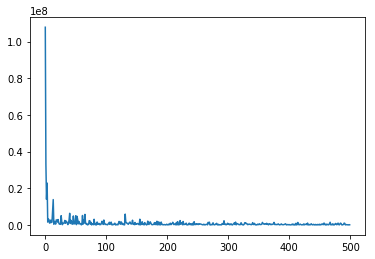

In [130]:
plt.figure()
plt.plot(losses_2)
plt.show()

In [131]:
index = 0
for index in [0, 44, 65, 22, 90]:
    pointer = list_times_ch_test[index]
    x = image_data[pointer]
    dim = x.shape[0]
    l = location[pointer]
    x = torch.from_numpy(x).float().cuda()
    ch = torch.from_numpy(np.array([pointer[1]])).float().cuda()
    out = cnn_1.forward(x, dim, ch)
    print(pointer)
    print(out)
    print(l)
    print('--------------')

(878177, 95)
tensor([  54.4523,  221.9390], device='cuda:2')
(61.067, 224.507)
--------------
(880652, 96)
tensor([ 48.3206,  27.5208], device='cuda:2')
(50.012, 29.363)
--------------
(881943, 2)
tensor([  62.1149,  262.1317], device='cuda:2')
(67.13, 252.341)
--------------
(879457, 93)
tensor([ 54.6948,  59.5756], device='cuda:2')
(43.886, 29.969)
--------------
(883433, 60)
tensor([  18.2093,  209.6095], device='cuda:2')
(10.61, 161.915)
--------------


## With Dilation

In [166]:
epoch_range = 50
batch_size = 200
learning_rate = 0.0001

cnn_3 = LocatorCNN(dilate=2).cuda()
cnn_3.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_3.parameters(), lr=learning_rate)

out, losses_3 = train_cnn(cnn_3, list_times_ch_train, image_data, location, criterion, optimizer, epoch_range, batch_size)

epoch [1/50], loss:1152.67432, avg:1152.67432
epoch [2/50], loss:691.47363, avg:922.07397
epoch [3/50], loss:557.33044, avg:800.49286
epoch [4/50], loss:371.27533, avg:693.18848
epoch [5/50], loss:150.93750, avg:584.73828
epoch [6/50], loss:225.62125, avg:524.88550
epoch [7/50], loss:13.27343, avg:451.79803
epoch [8/50], loss:11.38872, avg:396.74686
epoch [9/50], loss:1.09680, avg:352.78574
epoch [10/50], loss:78.57224, avg:325.36438
epoch [11/50], loss:154.75427, avg:225.57237
epoch [12/50], loss:39.52754, avg:160.37775
epoch [13/50], loss:384.58121, avg:143.10283
epoch [14/50], loss:19.51732, avg:107.92702
epoch [15/50], loss:147.79594, avg:107.61287
epoch [16/50], loss:341.64035, avg:119.21478
epoch [17/50], loss:118.39520, avg:129.72696
epoch [18/50], loss:6.63201, avg:129.25128
epoch [19/50], loss:166.57626, avg:145.79924
epoch [20/50], loss:56.43832, avg:143.58585
epoch [21/50], loss:69.20965, avg:135.03137
epoch [22/50], loss:210.74570, avg:152.15320
epoch [23/50], loss:24.79057

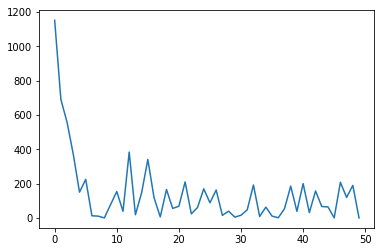

In [168]:
plt.figure()
plt.plot(losses_3)
plt.show()

In [172]:
index = 0
for index in [0, 44, 65, 22, 90]:
    pointer = list_times_ch_test[index]
    x = image_data[pointer]
    dim = x.shape[0]
    l = location[pointer]
    x = torch.from_numpy(x).float().cuda()
    ch = torch.from_numpy(np.array([pointer[1]])).float().cuda()
    out = cnn_3.forward(x, dim, ch)
    print(pointer)
    print(out)
    print(l)
    print('--------------')

(878177, 95)
tensor([  55.2518,  216.6100], device='cuda:1')
(61.067, 224.507)
--------------
(880652, 96)
tensor([ 48.7046,  24.6939], device='cuda:1')
(50.012, 29.363)
--------------
(881943, 2)
tensor([  67.9019,  266.0894], device='cuda:1')
(67.13, 252.341)
--------------
(879457, 93)
tensor([ 52.7449,  41.0826], device='cuda:1')
(43.886, 29.969)
--------------
(883433, 60)
tensor([  31.8485,  248.6317], device='cuda:1')
(10.61, 161.915)
--------------


# New Model - Branched Convolutional Network

In [113]:
torch.cuda.set_device(0)

class LocatorCNN_XY(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN_XY, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, dilation=dilate)
        self.batchnorm1 = nn.BatchNorm2d(32)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, dilation=dilate)
        
        self.conv_layer5 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.1)
        self.drop1 = nn.Dropout(p=0.05)
        
        self.activation_layer_2d = nn.Sigmoid()
        self.activation_layer = nn.PReLU()
        
        self.linear_1 = None
        
        if dilate == 1:
            self.linear_1 = nn.Linear(131072, 2048) #Without dilation
        elif dilate == 2:
            self.linear_1 = nn.Linear(115200, 2048) #with dilation=2
        
        self.linear_2_x = nn.Linear(2048, 512)
        self.linear_3_x = nn.Linear(512, 128)
        self.linear_4_x = nn.Linear(128, 32)
        self.linear_5_x = nn.Linear(33, 8)
        self.linear_6_x = nn.Linear(8, 1)
        
        self.linear_2_y = nn.Linear(2048, 512)
        self.linear_3_y = nn.Linear(512, 128)
        self.linear_4_y = nn.Linear(128, 32)
        self.linear_5_y = nn.Linear(33, 8)
        self.linear_6_y = nn.Linear(8, 1)
    
    def forward(self, x, dim, channel):
        x = x.view((1, 1, dim, -1))
        channel = channel.view(-1)

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        out = self.conv_layer2(out)
        out = self.batchnorm1(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        
        out = self.conv_layer5(out)
        out = self.activation_layer_2d(out)
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        
        out = out.view(-1)
        
        out = self.linear_1(out)
        out = self.activation_layer(out)
        
        out_x = self.linear_2_x(out)
        out_x = self.activation_layer(out_x)
        out_x = self.drop1(out_x)
        out_x = self.linear_3_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = self.linear_4_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = torch.cat((out_x, channel))
        out_x = self.linear_5_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = self.linear_6_x(out_x)
        
        out_y = self.linear_2_y(out)
        out_y = self.activation_layer(out_y)
        out_y = self.drop1(out_y)
        out_y = self.linear_3_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = self.linear_4_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = torch.cat((out_y, channel))
        out_y = self.linear_5_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = self.linear_6_y(out_y)
        
        final = torch.cat((out_x, out_y)).view(-1)
        
        return final

In [107]:
import random
random.seed(0)

def train_cnn(model, times_ch, images, location, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, len(times_ch)), batch_size)
        for i in range(len(selected)):
            pointer = times_ch[i]
            x = images[pointer]
            dim = x.shape[0]
            x = torch.from_numpy(x).float().cuda()
            ch = torch.from_numpy(np.array([pointer[1]])).float().cuda()
            #---------FORWARD------------#
            out = model.forward(x, dim, ch)
            out = torch.tensor(out).float().cuda()
            loc = np.array(location[pointer])
            #print(loc)
            loc = torch.from_numpy(loc).float().cuda()
            #print(pointer, out, loc)
            loss1 = criterion(out[0], loc[0])
            loss2 = criterion(out[1], loc[1])
            #---------BACKWARD------------#
            optimizer.zero_grad()
            (loss1+loss2).backward()
            optimizer.step()
            
        losses.append((loss1.data[0]+loss2.data[0]))
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              (loss1.data[0]+loss2.data[0]), sum(losses[-10:])/len(losses[-10:])))
    return out, losses

In [116]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [99]:
#print(image_data.keys())
#print(list_times_ch_train)
#print(location.values())

In [121]:
epoch_range = 500
batch_size = 200
learning_rate = 0.00001

cnn_xy_1 = LocatorCNN_XY().cuda()
cnn_xy_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_xy_1.parameters(), lr=learning_rate)

out, losses_xy = train_cnn(cnn_xy_1, list_times_ch_train, image_data, location, criterion, optimizer, epoch_range, batch_size)

epoch [1/500], loss:21944.94336, avg:21944.94336
epoch [2/500], loss:20075.59961, avg:21010.27148
epoch [3/500], loss:22111.49023, avg:21377.34375
epoch [4/500], loss:20256.76953, avg:21097.19922
epoch [5/500], loss:25392.10156, avg:21956.17969
epoch [6/500], loss:16246.11523, avg:21004.50391
epoch [7/500], loss:22042.67188, avg:21152.81250
epoch [8/500], loss:17096.79688, avg:20645.81055
epoch [9/500], loss:21276.25977, avg:20715.86133
epoch [10/500], loss:19625.57031, avg:20606.83203
epoch [11/500], loss:26471.34375, avg:21059.47266
epoch [12/500], loss:17525.76953, avg:20804.49023
epoch [13/500], loss:19603.59570, avg:20553.69922
epoch [14/500], loss:18530.10352, avg:20381.03320
epoch [15/500], loss:23212.02930, avg:20163.02734
epoch [16/500], loss:16206.73633, avg:20159.08789
epoch [17/500], loss:23597.23047, avg:20314.54492
epoch [18/500], loss:24036.67969, avg:21008.53125
epoch [19/500], loss:13950.84180, avg:20275.99023
epoch [20/500], loss:17692.12891, avg:20082.64648
epoch [21

epoch [164/500], loss:21776.36719, avg:21293.37891
epoch [165/500], loss:21029.85156, avg:21088.36328
epoch [166/500], loss:19484.10742, avg:20831.23047
epoch [167/500], loss:20189.54102, avg:20780.23242
epoch [168/500], loss:22317.37109, avg:21238.98242
epoch [169/500], loss:20250.99023, avg:20998.39453
epoch [170/500], loss:23559.38672, avg:20906.86328
epoch [171/500], loss:20254.50195, avg:20908.81055
epoch [172/500], loss:20743.32617, avg:20971.04492
epoch [173/500], loss:19188.26758, avg:20879.37109
epoch [174/500], loss:20203.89648, avg:20722.12305
epoch [175/500], loss:19590.53516, avg:20578.19141
epoch [176/500], loss:18340.62305, avg:20463.84375
epoch [177/500], loss:20611.04883, avg:20505.99414
epoch [178/500], loss:17323.41992, avg:20006.59961
epoch [179/500], loss:22490.54102, avg:20230.55664
epoch [180/500], loss:18556.05664, avg:19730.22461
epoch [181/500], loss:19760.31250, avg:19680.80469
epoch [182/500], loss:19828.61719, avg:19589.33203
epoch [183/500], loss:22143.828

epoch [325/500], loss:19475.41406, avg:19465.85742
epoch [326/500], loss:18556.90039, avg:19365.15625
epoch [327/500], loss:19220.99023, avg:19318.77734
epoch [328/500], loss:20011.21289, avg:19650.26367
epoch [329/500], loss:20943.47266, avg:19806.75977
epoch [330/500], loss:24361.94141, avg:20159.25000
epoch [331/500], loss:20156.41992, avg:20191.41406
epoch [332/500], loss:19031.25000, avg:19794.64062
epoch [333/500], loss:18262.70312, avg:19925.75000
epoch [334/500], loss:19655.43750, avg:19967.57422
epoch [335/500], loss:19357.36133, avg:19955.76953
epoch [336/500], loss:20823.41797, avg:20182.42188
epoch [337/500], loss:19984.99414, avg:20258.82227
epoch [338/500], loss:18269.13672, avg:20084.61523
epoch [339/500], loss:20314.84180, avg:20021.75195
epoch [340/500], loss:19971.61523, avg:19582.71875
epoch [341/500], loss:20249.64844, avg:19592.04102
epoch [342/500], loss:16941.61523, avg:19383.07617
epoch [343/500], loss:19854.52539, avg:19542.25781
epoch [344/500], loss:19756.570

epoch [486/500], loss:21309.83398, avg:19260.57031
epoch [487/500], loss:19212.45898, avg:19201.02539
epoch [488/500], loss:18554.33203, avg:19059.07617
epoch [489/500], loss:18217.71094, avg:19076.29688
epoch [490/500], loss:17520.65820, avg:18891.30078
epoch [491/500], loss:18788.01562, avg:18853.48047
epoch [492/500], loss:19256.91406, avg:18910.61914
epoch [493/500], loss:18524.36523, avg:18966.16406
epoch [494/500], loss:19379.64648, avg:19007.56641
epoch [495/500], loss:18878.97852, avg:18964.29102
epoch [496/500], loss:19402.69531, avg:18773.57812
epoch [497/500], loss:18338.10938, avg:18686.14258
epoch [498/500], loss:18743.44727, avg:18705.05469
epoch [499/500], loss:20290.46289, avg:18912.33203
epoch [500/500], loss:19357.58203, avg:19096.02148


<IPython.core.display.Javascript object>


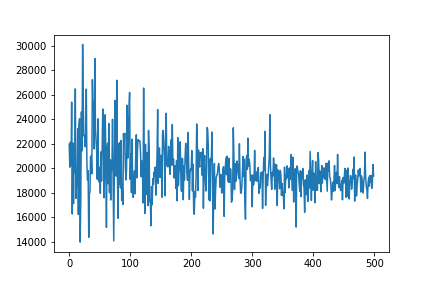

In [122]:
plt.figure()
plt.plot(losses_xy)
plt.show()

In [123]:
index = 0
for index in [0, 44, 65, 22, 90]:
    pointer = list_times_ch_test[index]
    x = image_data[pointer]
    dim = x.shape[0]
    l = location[pointer]
    x = torch.from_numpy(x).float().cuda()
    ch = torch.from_numpy(np.array([pointer[1]])).float().cuda()
    out = cnn_xy_1.forward(x, dim, ch)
    print(pointer)
    print(out)
    print(l)
    print('--------------')

(24, 927119)
tensor([ 63289.3047,  18902.5781], device='cuda:0')
(91.96037958183258, 114.69148692316693)
--------------
(27, 928120)
tensor([ 63374.2031,  18924.7773], device='cuda:0')
(43.03259679874801, 142.414760948499)
--------------
(1, 928579)
tensor([ 63380.5312,  18934.0977], device='cuda:0')
(-15.481029003693855, -14.975225920985395)
--------------
(19, 927542)
tensor([ 63315.7695,  18914.0215], device='cuda:0')
(43.73117057110287, 81.61044728225859)
--------------
(29, 929172)
tensor([ 63411.0977,  18944.5137], device='cuda:0')
(2.0629572306957584, 159.0798804374282)
--------------


In [319]:
epoch_range = 500
batch_size = 200
learning_rate = 0.00001

cnn_xy_2 = LocatorCNN_XY(dilate=2).cuda()
cnn_xy_2.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_xy_2.parameters(), lr=learning_rate)

out, losses_xy_2 = train_cnn(cnn_xy_2, list_times_ch_train, image_data, location, criterion, optimizer, epoch_range, batch_size)

epoch [1/500], loss:12225.57129, avg:12225.57129
epoch [2/500], loss:223.94885, avg:6224.76025
epoch [3/500], loss:578.07404, avg:4342.53174
epoch [4/500], loss:13.21645, avg:3260.20288
epoch [5/500], loss:86.47015, avg:2625.45630
epoch [6/500], loss:25.31837, avg:2192.10010
epoch [7/500], loss:56.39300, avg:1886.99902
epoch [8/500], loss:82.33234, avg:1661.41553
epoch [9/500], loss:6.81297, avg:1477.57080
epoch [10/500], loss:277.73959, avg:1357.58765
epoch [11/500], loss:28.02992, avg:137.83357
epoch [12/500], loss:52.78170, avg:120.71686
epoch [13/500], loss:174.46812, avg:80.35625
epoch [14/500], loss:244.88579, avg:103.52319
epoch [15/500], loss:27.83635, avg:97.65982
epoch [16/500], loss:43.64218, avg:99.49220
epoch [17/500], loss:18.36543, avg:95.68945
epoch [18/500], loss:336.24841, avg:121.08105
epoch [19/500], loss:139.90562, avg:134.39032
epoch [20/500], loss:84.10506, avg:115.02686
epoch [21/500], loss:125.55120, avg:124.77898
epoch [22/500], loss:40.52803, avg:123.55363
ep

epoch [184/500], loss:20.51293, avg:45.05052
epoch [185/500], loss:7.97392, avg:45.48597
epoch [186/500], loss:20.35228, avg:41.01541
epoch [187/500], loss:33.97345, avg:43.21231
epoch [188/500], loss:6.58901, avg:37.98479
epoch [189/500], loss:3.00376, avg:34.30561
epoch [190/500], loss:23.56203, avg:20.43498
epoch [191/500], loss:26.44173, avg:21.22603
epoch [192/500], loss:4.36173, avg:20.90976
epoch [193/500], loss:2.08688, avg:14.88577
epoch [194/500], loss:8.49423, avg:13.68390
epoch [195/500], loss:61.30681, avg:19.01719
epoch [196/500], loss:3.28815, avg:17.31078
epoch [197/500], loss:7.82834, avg:14.69627
epoch [198/500], loss:36.28529, avg:17.66590
epoch [199/500], loss:18.81313, avg:19.24683
epoch [200/500], loss:90.86115, avg:25.97674
epoch [201/500], loss:12.30172, avg:24.56274
epoch [202/500], loss:1.02983, avg:24.22956
epoch [203/500], loss:4.40979, avg:24.46185
epoch [204/500], loss:3.67930, avg:23.98035
epoch [205/500], loss:21.51665, avg:20.00134
epoch [206/500], loss

epoch [367/500], loss:0.12912, avg:5.16251
epoch [368/500], loss:0.81953, avg:4.21515
epoch [369/500], loss:45.61509, avg:7.74592
epoch [370/500], loss:39.43488, avg:11.59982
epoch [371/500], loss:2.47240, avg:10.78058
epoch [372/500], loss:2.65298, avg:10.65011
epoch [373/500], loss:48.19004, avg:14.79659
epoch [374/500], loss:40.82755, avg:18.06891
epoch [375/500], loss:120.21117, avg:30.04620
epoch [376/500], loss:4.99970, avg:30.53525
epoch [377/500], loss:40.63163, avg:34.58549
epoch [378/500], loss:102.34177, avg:44.73772
epoch [379/500], loss:76.97678, avg:47.87389
epoch [380/500], loss:123.29952, avg:56.26035
epoch [381/500], loss:27.14441, avg:58.72755
epoch [382/500], loss:7.85330, avg:59.24759
epoch [383/500], loss:2.25872, avg:54.65446
epoch [384/500], loss:2.50963, avg:50.82266
epoch [385/500], loss:0.72742, avg:38.87429
epoch [386/500], loss:0.47032, avg:38.42135
epoch [387/500], loss:0.84397, avg:34.44258
epoch [388/500], loss:3.01334, avg:24.50974
epoch [389/500], loss:

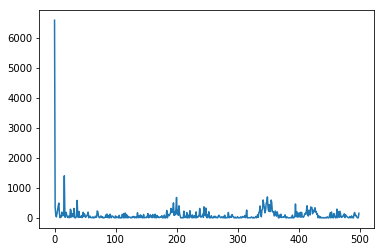

In [320]:
plt.figure()
plt.plot(losses_xy)
plt.show()

In [321]:
index = 0
for index in [0, 44, 65, 22, 90]:
    pointer = list_times_ch_test[index]
    x = image_data[pointer]
    dim = x.shape[0]
    l = location[pointer]
    x = torch.from_numpy(x).float().cuda()
    ch = torch.from_numpy(np.array([pointer[1]])).float().cuda()
    out = cnn_xy_2.forward(x, dim, ch)
    print(pointer)
    print(out)
    print(l)
    print('--------------')

(878178, 95)
tensor([  61.1443,  236.1344], device='cuda:1')
(61.067, 224.507)
--------------
(880653, 96)
tensor([ 59.0931,  32.7004], device='cuda:1')
(50.012, 29.363)
--------------
(881944, 2)
tensor([  59.3295,  260.3108], device='cuda:1')
(67.13, 252.341)
--------------
(879458, 93)
tensor([ 49.3011,  30.6260], device='cuda:1')
(43.886, 29.969)
--------------
(883434, 60)
tensor([  11.5948,  212.4778], device='cuda:1')
(10.61, 161.915)
--------------


In [322]:
torch.save(cnn_xy_1, 'models/visapy/cnn_undilated.pt') #Saving the CNN-undilated model
torch.save(cnn_xy_2, 'models/visapy/cnn_dilated.pt') #Saving the CNN-dilated model